In [6]:
import pandas as pd

In [7]:
df=pd.read_csv('/content/merged_hourly_load_weather (1).csv')

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [9]:
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m
datetime,,,,,,,,,
2018-01-01 00:00:00,20905.32,11.4,81,0.0,1.9,22,0,1014.5,8.3
2018-01-01 01:00:00,18827.25,9.5,88,0.0,9.5,245,0,1014.5,7.5
2018-01-01 02:00:00,17624.49,8.6,88,0.0,6.0,253,0,1013.8,6.8
2018-01-01 03:00:00,17092.84,8.2,88,0.0,7.3,261,0,1013.5,6.3
2018-01-01 04:00:00,17661.66,7.9,88,0.0,8.0,275,0,1013.3,6.0


In [10]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_year"] = df.index.day_of_year
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m,hour,dayofweek,month,day_of_month,day_of_year,year,week_of_year
datetime,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,20905.32,11.4,81,0.0,1.9,22,0,1014.5,8.3,0,0,1,1,1,2018,1
2018-01-01 01:00:00,18827.25,9.5,88,0.0,9.5,245,0,1014.5,7.5,1,0,1,1,1,2018,1
2018-01-01 02:00:00,17624.49,8.6,88,0.0,6.0,253,0,1013.8,6.8,2,0,1,1,1,2018,1
2018-01-01 03:00:00,17092.84,8.2,88,0.0,7.3,261,0,1013.5,6.3,3,0,1,1,1,2018,1
2018-01-01 04:00:00,17661.66,7.9,88,0.0,8.0,275,0,1013.3,6.0,4,0,1,1,1,2018,1


In [11]:
!pip install tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
threshold_date_1 = "01-01-2024"
threshold_date_2 = "01-01-2025"

In [13]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

## Feature Selection

In [ ]:
FEATURES = ["hour", "day_of_month", "dayofweek", "day_of_year", "month", "year", "week_of_year", "temperature_2m", "relative_humidity_2m",	"windspeed_10m", "dew_point_2m"]
TARGET = "load"
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = train_data_keras_s[:, :-1].reshape(train_data_keras_s.shape[0], 1, len(FEATURES))
y_train_keras = train_data_keras_s[:, -1]
X_test_keras = test_data_keras_s[:, :-1].reshape(test_data_keras_s.shape[0], 1, len(FEATURES))
y_test_keras = test_data_keras_s[:, -1]

### LSTM Model

In [ ]:
# Train initial LSTM model
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# Print the model summary to check the structure
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,689 (1.05 MB)

 Trainable params: 274,689 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')
model_checkpoint = ModelCheckpoint('delhilstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min'
)
model.fit(X_train_keras, y_train_keras, epochs=100, batch_size=144, validation_data=(X_test_keras, y_test_keras), callbacks=[early_stopping, model_checkpoint, reduce_lr_loss])

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1364 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0990 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0981 - val_loss: 0.1084 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0964 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0957 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0937 - val_loss: 0.1117 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0920 - val_loss: 0.1041 - learning_rate: 0.0010
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0918 - val_loss: 0.1054 - learning_rate: 0.0010
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0910 - val_loss: 0.1030 - learning_rate:

### LSTM Model Prediction

In [ ]:
# Evaluate and save metrics for initial LSTM
pred_lstm = model.predict(X_test_keras)
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)
results_lstm = scaler.inverse_transform(results_lstm)
result_frame_lstm = pd.DataFrame(index=test_data.index)
result_frame_lstm["load"] = test_data["load"]
result_frame_lstm["pred_lstm"] = results_lstm[:, -1]
mape_lstm = np.mean(np.abs((result_frame_lstm["load"] - result_frame_lstm["pred_lstm"]) / result_frame_lstm["load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["load"] - result_frame_lstm["pred_lstm"])))

print(f"MAPE of Initial LSTM Model: {mape_lstm:.2f}%")
print(f"RMSE of Initial LSTM Model: {rmse_lstm:.2f} MW")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE of Initial LSTM Model: 10.85%
RMSE of Initial LSTM Model: 6305.83 MW


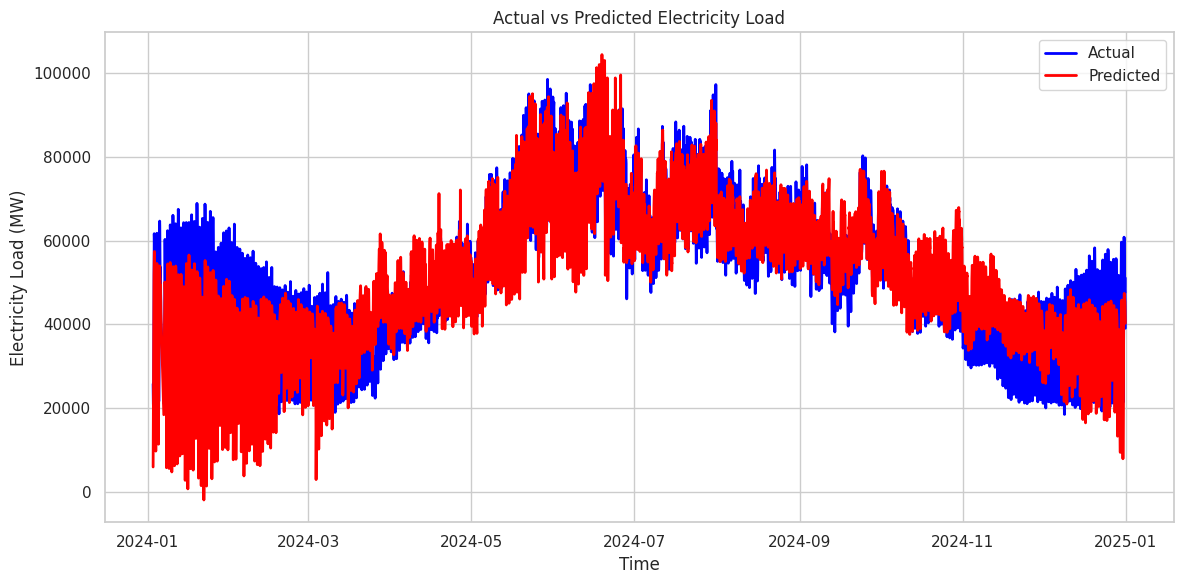

In [ ]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

# Set general plot aesthetics
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual vs Predicted using seaborn styling
ax.plot(result_frame_lstm.index, result_frame_lstm['load'], label='Actual', color='blue', linewidth=2)
ax.plot(result_frame_lstm.index, result_frame_lstm['pred_lstm'], label='Predicted', color='red', linewidth=2)

# Customize axes
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### Deep LSTM Model

In [ ]:
# Define the deep LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences for the next LSTM layer
model.add(LSTM(units=256, activation='tanh', input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Second LSTM layer with 50 units
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Third LSTM layer with 50 units
model.add(LSTM(units=32, activation='tanh', return_sequences=False))  # Last LSTM layer, return_sequences=False
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Fully connected layer to output the predicted load
model.add(Dense(units=1))  # Output layer with 1 neuron (regression)

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Print the model summary
model.summary()

# Train the model
model.fit(X_train_keras, y_train_keras, epochs=100, batch_size=144, validation_data=(X_test_keras, y_test_keras),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr_loss])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 1, 256)         │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,193 (1.88 MB)

 Trainable params: 492,193 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.1680 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.1080 - val_loss: 0.1285 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0995 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0940 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0916 - val_loss: 0.0965 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0886 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0851 - val_loss: 0.0881 - learning_rate: 0.0010
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0806 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0770 - val_loss: 0.0740 - learn

### Deep LSTM Model Prediction

In [ ]:
# Evaluate and save metrics for initial LSTM
pred_lstm = model.predict(X_test_keras)
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)
results_lstm = scaler.inverse_transform(results_lstm)
result_frame_lstm = pd.DataFrame(index=test_data.index)
result_frame_lstm["load"] = test_data["load"]
result_frame_lstm["pred_lstm"] = results_lstm[:, -1]
mape_lstm = np.mean(np.abs((result_frame_lstm["load"] - result_frame_lstm["pred_lstm"]) / result_frame_lstm["load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["load"] - result_frame_lstm["pred_lstm"])))

print(f"MAPE of Initial LSTM Model: {mape_lstm:.2f}%")
print(f"RMSE of Initial LSTM Model: {rmse_lstm:.2f} MW")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAPE of Initial LSTM Model: 8.35%
RMSE of Initial LSTM Model: 5639.31 MW


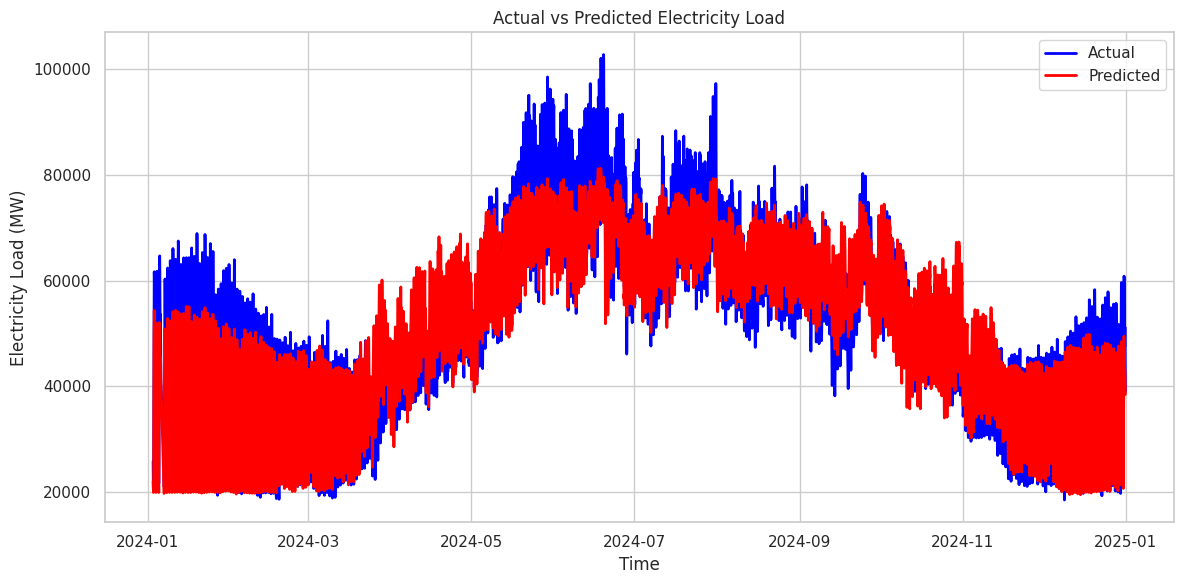

In [ ]:
# Set general plot aesthetics
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual vs Predicted using seaborn styling
ax.plot(result_frame_lstm.index, result_frame_lstm['load'], label='Actual', color='blue', linewidth=2)
ax.plot(result_frame_lstm.index, result_frame_lstm['pred_lstm'], label='Predicted', color='red', linewidth=2)

# Customize axes
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.save("deeplstm.keras")